In [1]:
import numpy as np
import pandas as pd
import os, time, random, warnings
from tqdm import tqdm

from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

from transformers import BertTokenizer, TFBertModel

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)
    

CFG = {
'epochs' : 20,
'batch_size' : 32*strategy.num_replicas_in_sync,
'random_seed' : 42,
'max_len' : 100,
'validation_split':0.2
}



np.random.seed(CFG['random_seed'])
tf.random.set_seed(CFG['random_seed'])
os.environ["WANDB_API_KEY"] = "0" ## to silence warning
warnings.simplefilter("ignore")

ModuleNotFoundError: No module named 'plotly'

In [2]:
train_df = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
train_df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [3]:
iplot(px.pie(train_df,names='language',title='Languages counts'))

In [4]:
iplot(px.pie(train_df,names='label',title='Languages counts'))

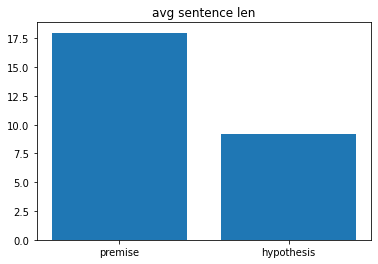

In [5]:
plt.bar(['premise','hypothesis'],[np.mean([len(i) for i in train_df['premise'].apply(lambda x: x.split())]),np.mean([len(i) for i in train_df['hypothesis'].apply(lambda x: x.split())])])
plt.title('avg sentence len')
plt.show()

In [6]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [7]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [8]:
def bert_encode(premises,hypothesis,tokenize):
    
    num_examples = len(hypothesis)
    
    sentence1 = tf.ragged.constant([
        encode_sentence(s) for s in np.array(premises)
    ])
    
    sentence2 = tf.ragged.constant([
        encode_sentence(s) for s in np.array(hypothesis)
    ])
    
    cls = [tokenizer.convert_tokens_to_ids(['[SEP]'])]*sentence1.shape[0]
    
    input_words_ids = tf.concat([cls,sentence1,sentence2],axis=-1)
    
    input_mask=tf.ones_like(input_words_ids)
    
    type_cls = tf.zeros_like(cls)
    type_sentence1 = tf.zeros_like(sentence1)
    type_sentence2 = tf.ones_like(sentence2)
    
    input_type_ids = tf.concat([type_cls,type_sentence1,type_sentence2],axis=-1)
    
    inputs={
        'input_words_ids' :input_words_ids.to_tensor(),
        'input_mask' : input_mask.to_tensor(),
        'input_type_ids' : input_type_ids.to_tensor()
    }
    
    return inputs

In [9]:
input_train = bert_encode(train_df.premise.values,train_df.hypothesis.values,tokenizer)

# input_val = dict()
# val_start = int(len(train_df.label.values)*CFG['validation_split'])

# for key in input_train.keys():
#     input_val[key] =input_train[key][val_start:]
#     input_train[key] = input_train[key][:val_start]

In [10]:
maxlen = CFG['max_len']

def build_model(l):
    bert_encoder = TFBertModel.from_pretrained(model_name)
    
    input_words_ids = Input(shape=(maxlen),dtype=tf.int32,name='input_words_ids')
    input_mask = Input(shape=(maxlen,),dtype=tf.int32,name='input_mask')
    input_type_ids = Input(shape=(maxlen,),dtype=tf.int32,name='input_type_ids')
    
    embedding = bert_encoder([input_words_ids,input_mask,input_type_ids])[0]
    
    fc1 = Dense(1024,activation='relu')(embedding[:,0,:])
    drop = Dropout(0.2)(fc1)
    
    output = Dense(3,activation='softmax')(drop)
    
    
    model = Model(inputs=[input_words_ids,input_mask,input_type_ids],outputs=output)
    

    model.compile(
        optimizer = keras.optimizers.Adam(lr=l),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [11]:
# for e in range(3,4):
#     for l in [5e-5,3e-5,2e-5]:
        
#         with strategy.scope():
#             model = build_model(l)
        
#         print(f"----------------- epochs: {e} ,learning rate: {l} -----------------")
        
#         hist = model.fit(input_train,train_df.label.values,batch_size=CFG['batch_size'],epochs=e,verbose=1,validation_split=CFG['validation_split'])
        
        

In [12]:
with strategy.scope():
    model = build_model(l=1e-5)
    model.summary()
    
hist = model.fit(input_train,train_df.label.values,batch_size=CFG['batch_size'],epochs=CFG['epochs'],verbose=1)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words_ids (InputLayer)    [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 100, 768), ( 177853440   input_words_ids[0][0]            
                                                                 input_mask[0][0]            

In [13]:
test = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
input_test = bert_encode(test.premise.values,test.hypothesis.values,tokenizer)

preds = model.predict(input_test)

In [14]:
preds = [np.argmax(i) for i in preds]
preds

[2,
 1,
 0,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 2,
 0,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 1,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 1,


In [15]:
submission = pd.read_csv('../input/contradictory-my-dear-watson/sample_submission.csv')
submission

,id,prediction
0,c6d58c3f69,1
1,cefcc82292,1
2,e98005252c,1
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,1
5192,1f0ea92118,1
5193,0407b48afb,1


In [16]:
submission['prediction'] = preds
submission
submission.to_csv('submission.csv',index=False)